In [1]:
import os
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import factorial
from scipy import optimize
from matplotlib.pyplot import cm
from lmfit import Model
from matplotlib.gridspec import GridSpec
from scipy.stats import poisson as pois
from scipy.stats import norm

## Load Dataset

In [2]:
# load dataset including metadata info
def load_dataset(run, path='db/'):
    file = f'{path}AnalyzedDataFFT_Run_{run}_sliced.xlsx'
    meta = pd.read_excel(file,sheet_name=0,header=None)
    freq = pd.read_excel(file,sheet_name=1)             # frequecies
    fft  = pd.read_excel(file,sheet_name=2)             # power
    
    data = pd.DataFrame({'freq':freq[1]})
    
    col = 0
    for col_name in fft.columns: # load all the subruns
        if col > 0:
            data[f'fft{col-1}'] = fft[col_name]
        col += 1
    
    center = meta[1][3]
    
    print(f'Dataset loaded: {file}\nCavity frequency: {center} Hz\nfft subrun:{len(data.columns)-1}')
    
    return data,center

## Background and Signal Fits

### Prepare Data

In [28]:
def prep_data(alldata,center,subrun=0,bin_width=651,nbins=100):
    # set weights
    weights = alldata[f'fft{subrun}']/np.sqrt(1365500) # 1365500 vale solo per le run: 389,392,394,397,404
    #pesi[i] = alldata[f'fft{subrun}'][i]/np.sqrt(1365500) # 2731?? sono i millikelvin?
        
    # select window of 2*nbins bins around center
    # default is to select 200 bins of 651 Hz
    mask = (alldata['freq']>center-bin_width*nbins) & (alldata['freq']<center+bin_width*nbins)
    rawdata = alldata[mask]
    weights = weights[mask]
    
    # scale data to yottowat
    #display(rawdata)
    minW = rawdata.iloc[np.argmin(rawdata[f'fft{subrun}']),subrun + 1] # minimum power in the cavity, found
                                                                       # at the center of selected window = rv[100]
    ref = minW**(-1) * 3.5*1.38e-23*651/1e-24 #* 1e9 # EXTRA 1e15 to make it integer
    data = rawdata.copy()
    data[f'fft{subrun}'] = ref * rawdata[f'fft{subrun}']
    weights = weights*ref
    #print('dopo aver scalato')
    #display(data)
    
    freq = data['freq']
    fft=data[f'fft{subrun}']
    
    return(freq, fft, weights, ref)


### Fit Functions

In [29]:
def gaussian(x,x0,s,mu):
    return mu * np.exp(-.5*((x-x0)/s)**2)
    
def maxwell(x,x0,s,mu):
    return mu * x**2/s**3 * np.exp(-.5*((x-x0)/s)**2)
    
def bkg(x,a,b,c,d,e,f):                                                   
    return e**2*abs(x-a+1j*b)**2/abs(x-c+1j*d)**2+f*(x-c)
    
def signal_gauss(x,a,b,c,d,e,f,x0,s,mu):
    return bkg(x,a,b,c,d,e,f) + gaussian(x,x0,s,mu)
    
def signal_maxwell(x,a,b,c,d,e,f,x0,s,mu):
    return bkg(x,a,b,c,d,e,f) + maxwell(x,x0,s,mu)

### Fit Background

In [30]:
def fit_bkg(freq, fft, weights, center, ref):
    # set fit model
    bkg_model = Model(bkg)
    ps = bkg_model.make_params(a={'value':center, 'min':center*0.999, 'max':center*1.01},
                               b=2e4,
                               c={'value':center, 'min':center*0.999, 'max':center*1.01},
                               d=2.2e4,
                               e=1e-2*np.sqrt(ref),
                               f=1e-12*ref)
    # execute fit
    result = bkg_model.fit(fft,x=freq,params=ps,weights=1/weights) # aggiungere i pesi non cambia i parametri del fit,
                                                                   # nè il loro errore, 
                                # per aggiungerli dopo aver scalato i dati bisogna capire np.sqrt(length*2731)
    
    return(result)

### Fit Signal

In [31]:
def fit_sig(freq, fft, weights, x_0, res_bkg, signal, mu_init = 1e8, mu_vary = True):
    # take result of preliminary background fit to fix starting parameters
    p = res_bkg.best_values
    
    # set fit model
    sig_model = Model(signal)
    ps = sig_model.make_params(a ={'value':p['a'], 'vary':False},
                               b ={'value':p['b'], 'vary':False},
                               c ={'value':p['c'], 'vary':False},
                               d ={'value':p['d'], 'vary':False},
                               e ={'value':p['e'], 'vary':False},
                               f ={'value':p['f'], 'vary':False},
                               mu={'value':mu_init, 'min':0, 'vary':mu_vary},
                               x0={'value':x_0, 'vary':False},
                               s ={'value':16*651, 'vary':False}) # fixed value to 16 bins

    result = sig_model.fit(fft,x=freq,params=ps,weights=1/weights)
    
    return(result)

### Plot Fit Results

In [32]:
def plot_fit(freq, fft, weights, fit_result):
    # prepare canvas
    fig = plt.figure(figsize=(15,10))
    gs = GridSpec(2, 2)
    ax  = fig.add_subplot(gs[0,:])
    ax1 = fig.add_subplot(gs[1,0])
    ax2 = fig.add_subplot(gs[1,1])
    
    # plot data and best fit
    ax.plot(freq,fft,'o',label='data')
    ax.plot(freq,fit_result.best_fit,color='red',label='fit')
    #ax.set_ylim([4e-5,7e-5])
    fmin,fmax = min(freq),max(freq)
    ax.set_xlim([fmin,fmax])
    ax.legend()
    
    # plot histogrm of residuals
    fit_result.plot_residuals(ax=ax1,yerr=weights)
    ax2.hist(fit_result.residual)
    
    # plot of residuals vs. freq and error band
    sigma=fit_result.eval_uncertainty(x=freq)  
    fig3,ax3=plt.subplots(1,1,figsize=(18,5))
    ax3.scatter(freq,fit_result.residual*weights,label="residuals")
    ax3.plot(freq, weights,label="+$\sigma$")
    ax3.plot(freq,-weights,label="-$\sigma$")
    ax3.set_xlim([fmin,fmax])
    ax3.set_title("Residuals vs freq")
    ax3.legend()
    
    plt.show()

## Significance Test

### Generate Toy Datasets

In [33]:
def gen_toydataset(values, n):
    toy_dataset = pois.rvs(mu=values, size=(n,len(values)))
    return(toy_dataset)

### Likelihood Ratio

In [34]:
# compute likelihood ratios of two hypotheses
def lh_ratio(fft, model_null, model_alt):
    # compute log likelihoods
    LogLike_null = sum(pois.logpmf(fft.astype(int), model_null.best_fit.astype(int)))
    LogLike_alt  = sum(pois.logpmf(fft.astype(int), model_alt.best_fit.astype(int)))
    
    # significance of the test
    q = -2 * (LogLike_null - LogLike_alt)
    
    return(q)

### Plot Significance Distribution

In [35]:
def plot_significance(q0, q0_obs):
    # prepare canvas
    fig = plt.figure(figsize=(15,10))
    
    # plot q0 distribution
    N = len(q0)
    binning = int(np.sqrt(N))
    n, bins, _ = plt.hist(q0, bins=binning, density = True, 
                          facecolor='lightblue', edgecolor='black', label='Toy Experiments')
    plt.vlines(q0_obs, 0, max(n), colors='blue', linestyles='--', label='Observed Data')
    
    plt.legend(loc='upper left')
    plt.xlabel('q0')
    plt.ylabel('PDf')
    
    plt.show()

### Significance

In [36]:
def significance(freq, fft, weights, x_0, res_bkg, signal, n=1000, draw = False):
    res_sig = fit_sig(freq, fft, weights, x_0, res_bkg, signal)
    
    # compute likelihood ratio of observed data
    q0_obs = lh_ratio(fft, res_bkg, res_sig)
    
    # generate toy dataset and compute likelihood ratio for all of them
    toy_fft = gen_toydataset(res_bkg.best_fit, n)
    toy_weights = toy_fft/np.sqrt(1365500)
    
    q0 = np.zeros(n)
    for i in range(n):
        toy_bkg = fit_bkg(freq, toy_fft[i], toy_weights[i], center, ref)
        toy_sig = fit_sig(freq, toy_fft[i], toy_weights[i], x_0, toy_bkg, signal)
        q0[i] = lh_ratio(toy_fft[i], toy_bkg, toy_sig)
    
    # plot significance distribution
    if(draw):
        plot_significance(q0, q0_obs)
        
    # compute p-value
    p = sum(q0 >= q0_obs)/n
    # compute significance
    z = norm.ppf(1-p)
        
    return(z)

### Test

In [37]:
def sig_test(run, signal, path='db/', n=1000):
    data,center = load_dataset(run, path)
    freq, fft, weights, ref = prep_data(data,center)
    res_bkg = fit_bkg(freq, fft, weights, center, ref)
    
    z = np.zeros(len(freq))
    for i in range(len(freq)):
        z[i] = significance(freq, fft, weights, freq.values[i], res_bkg, signal, n)
    
    return(z)

# TEST

## Fit tests

In [38]:
data,center = load_dataset(395)
data

Dataset loaded: db/AnalyzedDataFFT_Run_395_sliced.xlsx
Cavity frequency: 10353468841.0 Hz
fft subrun:2


,freq,fft0,fft1
0,1.035200e+10,0.000048,0.000049
1,1.035200e+10,0.000048,0.000049
2,1.035200e+10,0.000048,0.000049
3,1.035200e+10,0.000048,0.000049
4,1.035200e+10,0.000048,0.000049
...,...,...,...
3067,1.035400e+10,0.000048,0.000049
3068,1.035400e+10,0.000048,0.000049
3069,1.035400e+10,0.000048,0.000049
3070,1.035400e+10,0.000048,0.000049


In [39]:
freq, fft, weights, ref = prep_data(data,center)
res_bkg = fit_bkg(freq, fft, weights, center, ref)
res_bkg

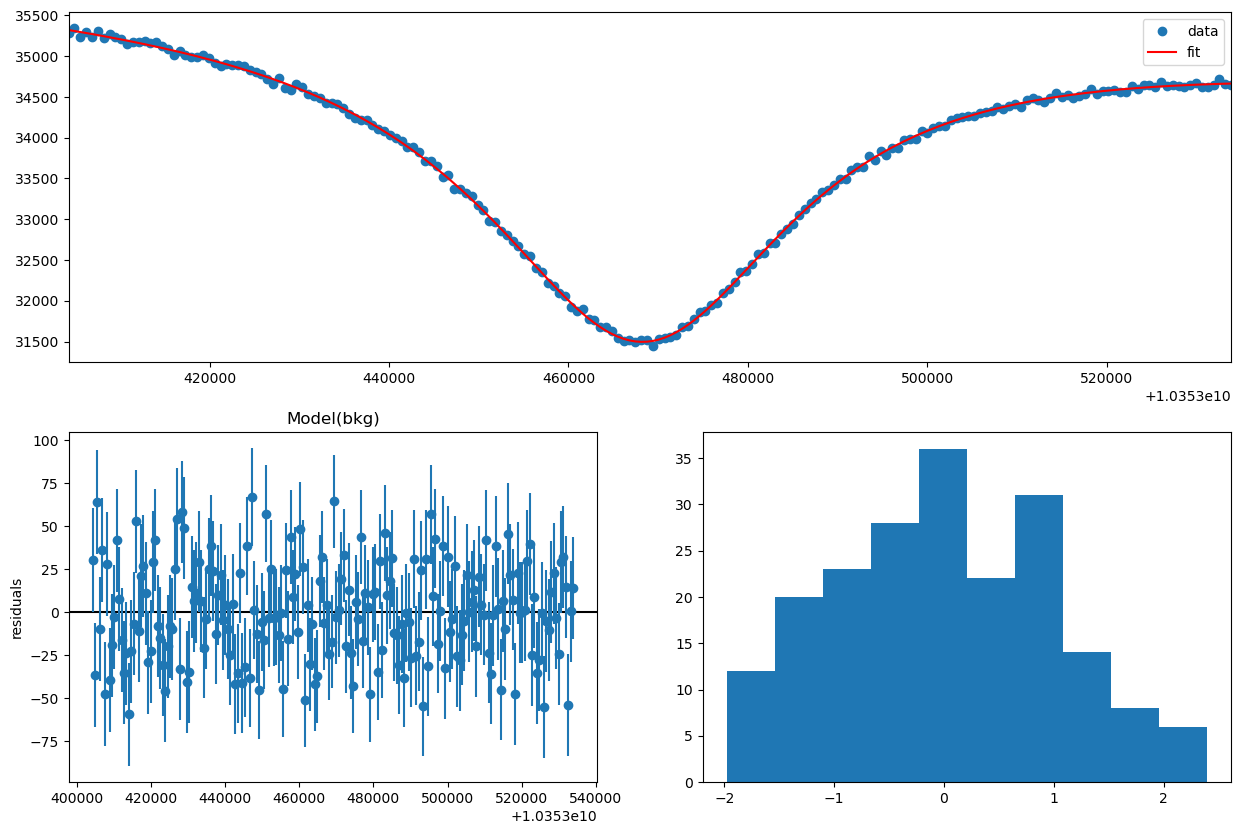

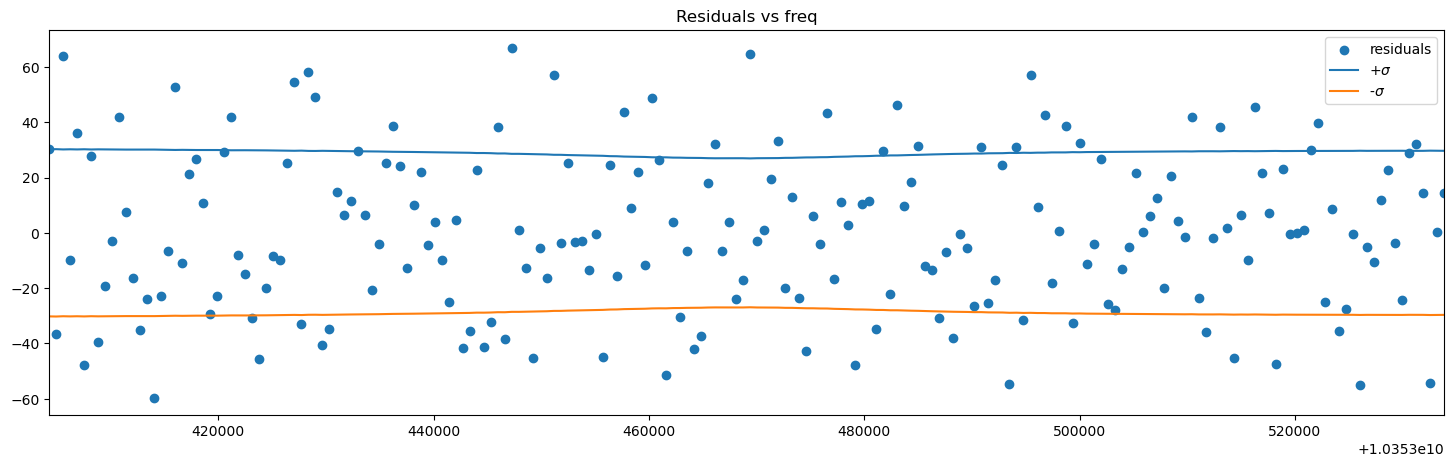

In [40]:
plot_fit(freq, fft, weights, res_bkg)

In [41]:
res_sig = fit_sig(freq, fft, weights, center, res_bkg, signal_maxwell)
res_sig

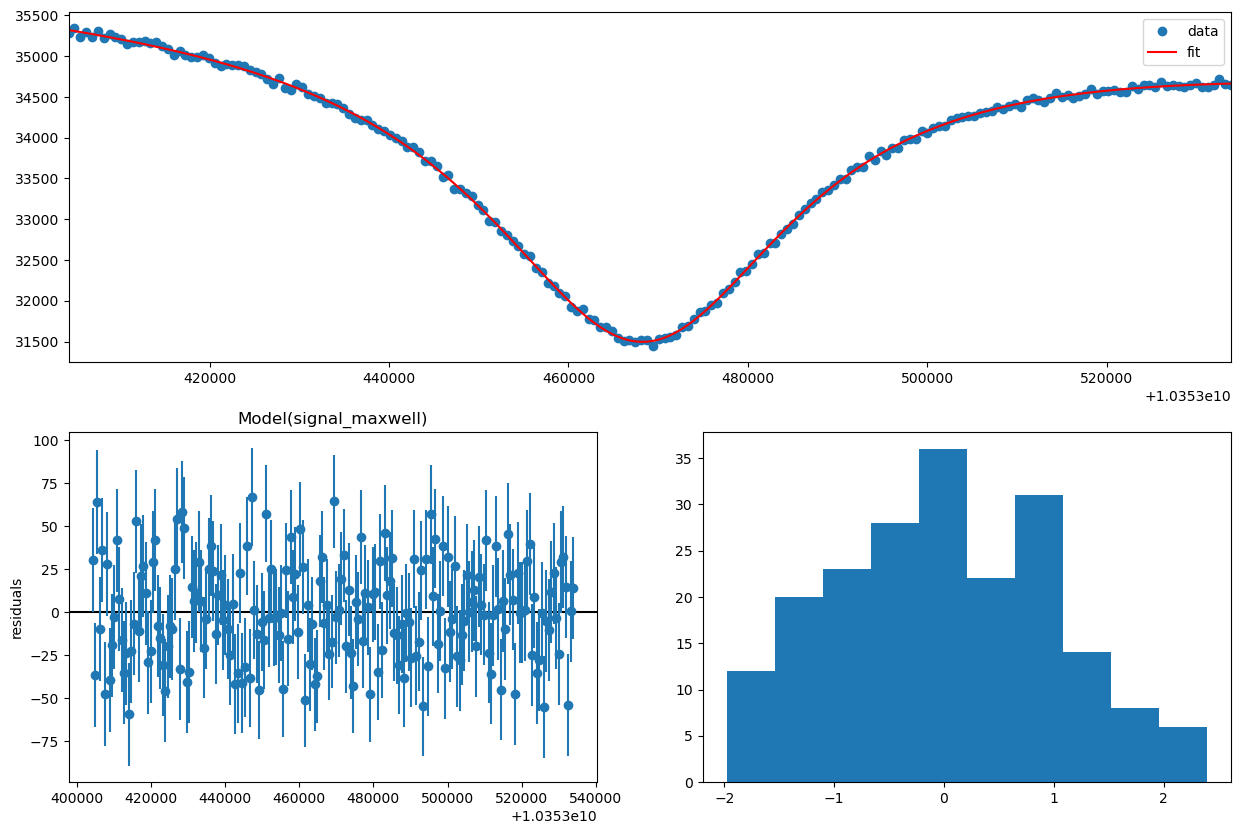

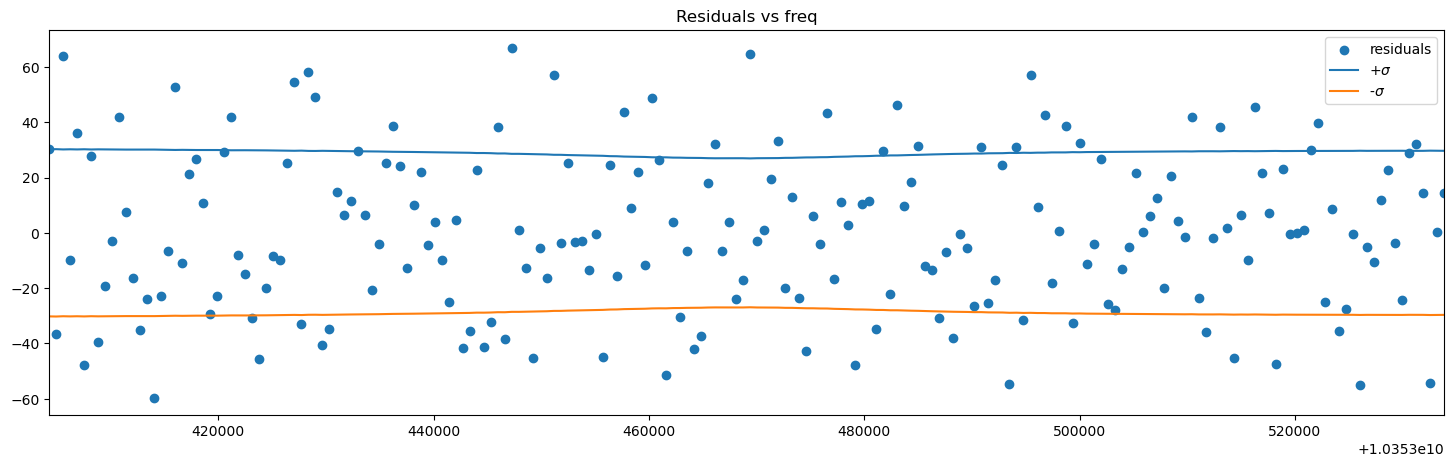

In [42]:
plot_fit(freq, fft, weights, res_sig)

## Significance Test

In [26]:
q0_obs = lh_ratio(fft, res_bkg, res_sig)
q0_obs

nan

In [27]:
z = significance(freq, fft, weights, center, res_bkg, signal_maxwell, 100, True)
z

ValueError: lam value too large